# Part I: Comunity Structure

We start by looking at the community structure of the the philosopher network. The community detection methods run on an undirected version of the philosopher graph, so create one of those. If your network has more than one component, just work on the _giant connected component_ (GCC).

**Data setup**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk, re, pprint
from __future__ import division
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

# load wiki data from earlier
with open("philosophers_domain.txt", "rb") as f:
    phil_domain = pickle.load(f) 
with open("philosophers_names.txt", "rb") as f:
    phil_names = pickle.load(f)
with open("philosophers_refs.txt", "rb") as f:
    phil_refs = pickle.load(f)
    
# create directed graph
G = nx.DiGraph()
G.add_nodes_from(phil_names)
G.add_edges_from([(phil, ref) for phil, refs in phil_refs.iteritems() for ref in list(refs)])

# create undirected graph
H = G.to_undirected()

# find ambiguous philosophers
ambiguous = set()
for branch1 in phil_domain:
    for branch2 in phil_domain:
        if not branch1 == branch2:
            commons = branch1.intersection(branch2)
            ambiguous = ambiguous.union(commons)
            
# find unambiguous philosophers by domain
unambiguous = [set(domain) - ambiguous for domain in phil_domain]

# sort ambiguous philosophers by neighbours most common domain
for phil in ambiguous:
    neighbours = set(H.neighbors(phil))
    domain = 0
    for branch, phils in enumerate(unambiguous):
        if len(neighbours.intersection(phils)) > domain:
            domain = branch
    unambiguous[domain].add(phil)

aesthetics, epistemology, ethics, logics, metaphysics, sociopolitical = unambiguous

We begin by using the concept of modularity to explore how _community-like_ the six branches of philosophy are. 

* Explain the concept of modularity in your own words.

**Answer:** Measures the fraction of edges which can be considered as a separate 'module' of densely connected nodes (a community) by identifying edges with higher betweenness than would be expected in a random network, i.e. the edges that connect the distinct modules to each other. (In similar terms, there should be fewer edges between modules than what would be expected in a random network.)

* Now, *calculate the modularity of the branches reported by the Wikipedia editors*. Modularity is described in the _Network Science_ book, section 9.4). Use **equation 9.12** in the book to calculate the modularity $M$ of the branches-partitioning. 

** Using equation 9.12 **
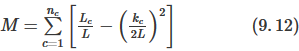

In [17]:
# find total degree of nodes in the group
def k_c(group):
    k_c = 0
    for phil in group:
        k_c += G.degree()[phil]
    return k_c

# find number of edges where both nodes are in group
def L_c(group):
    L_c = 0
    for edge in G.edges():
        nodes = set(edge)
        if group.issuperset(nodes):
            L_c += 1
    return L_c

# compute modularity using equation 9.12
def M(graph, groups):
    modularity = 0
    L = float(len(graph.edges()))
    for group in groups:
        Lc = L_c(group)
        kc = k_c(group)
        Mc = Lc/L - (kc/(2.0*L))**2.0
        modularity += Mc
    return modularity


# modularity using directed graph as basis
print "Modularity =", round(M(H, unambiguous),3)

Modularity = 0.172


* Comment on your value of $M$ for the branches. Are the branches good communities? (We will explore this question in depth below.)

** Answer: **
Our modularity is higher than zero, so we do at least capture something. But the partitioning provided by the wikipedia editors clearly isn't perfect in terms of modularity either.

* Now, let us use [the Python Louvain-algorithm implementation](http://perso.crans.org/aynaud/communities/) to find communities in the full philosopher network. 

Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the branches as communities? What does this comparison reveal about the branches? 




The giant connected component will be used in the upcoming calculations to dismiss very small and meaningless communities.

In [20]:
import community # Python Louvain-algorithm
# Find the giant connected component
GCC =  max(nx.connected_component_subgraphs(H), key=len)

partition = community.best_partition(GCC)
louvain = [set() for i in range(max(partition.values())+1)]
for phil, group in partition.iteritems():
    louvain[group].add(phil)

print "Modularity using Python Louvain:", M(GCC, louvain)

Modularity using Python Louvain: 0.528860823515


** Answer: **Clearly the partitions provided by the Louvain-algorithm provide much better modularity than the groups offered by Wikipedia (though they might not be as easily semantically interpretable).
It does tell us, however, that the six branches could easily be split into further sub-communities.


* Compare the communities found by your algorithm with the branches (that you analyzed abo ve) by creating a matrix **_D_** with dimension ($B$ times $C$), where $B$ is the number of branches and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that branch $i$ has in common with community $j$. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the labeled branches of philosophy.

In [21]:
B = len(unambiguous)
C = len(louvain)
D = np.matrix(np.zeros(shape=(B,C)))

for i, set1 in enumerate(unambiguous):
    for j, set2 in enumerate(louvain):
        D[i,j] = len(set1.intersection(set2))

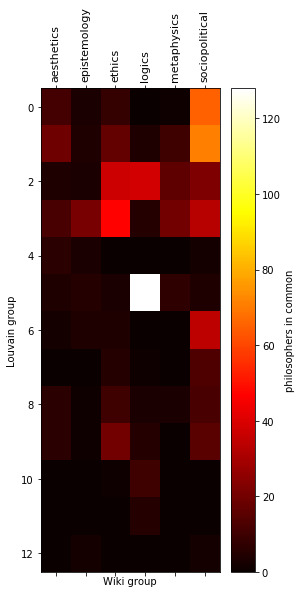

13


In [23]:
xticks = [[0,1,2,3,4,5], ["aesthetics", "epistemology", "ethics", "logics", "metaphysics", "sociopolitical"]]

plt.matshow(D.transpose(), cmap=plt.cm.hot, aspect='auto')
plt.colorbar().set_label('philosophers in common')
plt.xlabel("Wiki group")
plt.xticks(xticks[0], xticks[1], rotation='vertical', fontsize=11)
plt.ylabel("Louvain group")
plt.show()

*The confusion matrix displays the amount of common philosophers across the different branches of wikipedia and the Louvain groups*

**Answer: ** A few of the Louvain groups are well captured by the wikipedia branches. We find it surprising that the Louvain group 0 is spread over ethics and logics, two fields that seem otherwise unrelated. Louvain group 4 is grouped massively in Logics which makes sense to us, since Logics is fairly welldefined subject with little overlap to other fields.

Another interesting observation is that the majority of the groups are near-empty.
We decided to futher investigate this phenomenon:

In [14]:
solo_communities = 0
for i, s in enumerate(louvain):
    if len(s) == 1:
        solo_communities += 1    

print "Number of Louvain groups containing only 1 philosopher:", solo_communities

Number of Louvain groups containing only 1 philosopher: 224


From this it is clear that 224 of the Louvain groups are near-empty, meaning they hold only the minimum amount of philosophers, namely one philosopher per group.

To conclude, the confusion matrix reveals that the communities have a weak correspondence to the branches of philosophers.

# Part II: Human navigation paths 

This exercise works on the wikispeedia dataset. For details on wikispeedia, see [Lecture 8](http://nbviewer.jupyter.org/github/suneman/socialgraphs2016/blob/master/lectures/Week5.ipynb)

**Data setup:**


In [23]:
# load succesful human navigation paths
paths_succ = pd.read_csv("./Wikispeedia/paths_finished.tsv", skiprows=16, sep="\t", header=None)
paths_succ.columns = ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"]
paths_succ.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [24]:
# load Wikispeedia links
paths = pd.read_csv("./Wikispeedia/links.tsv", skiprows=12, sep="\t", header=None)
paths.columns = ["linkSource", "linkTarget"]
paths.head()

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


In [25]:
# create directed graph of Wikispedia links
wiki = nx.DiGraph()

for row in range(paths.shape[0]):
    wiki.add_edge(paths.iloc[row][0], paths.iloc[row][1])

print nx.info(wiki)

Name: 
Type: DiGraph
Number of nodes: 4592
Number of edges: 119882
Average in degree:  26.1067
Average out degree:  26.1067


### IIa: Path lengths

The first thing we want to take a look at is path lengths. NetworkX allows us to calculate the shortest path between any pair of articles. We begin by comparing the length of human and shortests paths. 

* For each _source_/_target_ pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths.



**Answer:** We calculate the shortest path lengths and save them in a list. Note that one of the paths are invalid which is caught and shown by the exception. We exclude this path for the following exercises.

In [26]:
# calculate lengths of shortest paths
shortest_paths = []
for row in range(paths_succ.shape[0]):
    try:
        n1 = paths_succ["path"][row].split(";")[0] # start node
        n2 = paths_succ["path"][row].split(";")[-1] # dest node
        shortest = nx.shortest_path_length(wiki, n1, n2)
        shortest_paths.append(shortest)
    except:
        print paths_succ["path"][row]
        pass

Bird;Wikipedia_Text_of_the_GNU_Free_Documentation_License


In [27]:
# drop invalid path, reset indices
paths_succ.drop(2395, inplace=True)
paths_succ.index = range(paths_succ.shape[0])

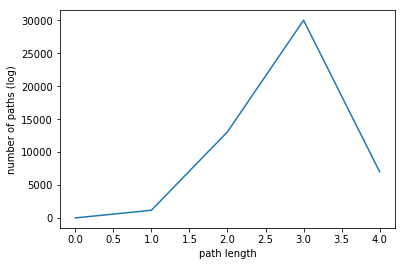

In [28]:
# generate histogram of shortest paths
shortest_hist = np.histogram(shortest_paths, bins=range(max(shortest_paths)))

plt.plot(shortest_hist[1][:-1], shortest_hist[0])
plt.xlabel("path length")
plt.ylabel("number of paths (log)")
plt.show()

*The graph shows that all pages can be found within 4 links. The majority can be reached in 3 links.*

*It should be noted that we have a lucky few starting in their destination page meaning they succeed in zero clicks.*

* For each _source_/_target_ pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths. 


**Answer:** Our answer assumes the person makes a satisfying choice from each page, so we disregard the pages where he/she decided to return to the previous page. 
This means that we disregard pages registered by the "<" icon as well as the page listed before it, since this would be the page to be returned from.

We did this since we are comparing the human paths with the computationally shortest paths and thought that it would be fair that the human is not penalized for exploring his options similarly to what the shortest path algorithm does under the hood.

In [30]:
# calculate lengths of human paths
human_paths = []
for row in range(paths_succ.shape[0]):
    p = paths_succ["path"][row].split(";")
    p_noback = [1 if page != '<' else -1 for page in p]
    human_paths.append(sum(p_noback))

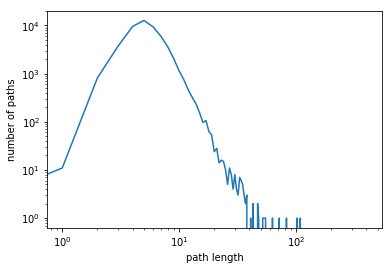

In [31]:
# generate histogram of human paths
human_hist = np.histogram(human_paths, bins=range(max(human_paths)))

plt.plot(human_hist[1][:-1], human_hist[0])
plt.xlabel("path length")
plt.ylabel("number of paths")
plt.xscale('log')
plt.yscale('log')
plt.show()

*From the graph it is evident that the majority of pages are found within the first 10 clicks and a minority of brave souls continue to more than a 100 clicks*

* How much longer are the human paths on average?


**Answer:** 

In [33]:
diff = round(np.mean(human_paths) - np.mean(shortest_paths), 1)

print "On average, the human paths are", diff, "clicks longer than the shortest paths"

On average, the human paths are 3.1 clicks longer than the shortest paths


* Create a scatter plot where each point is a _source_/_target_ pair, and you have human path lengths on the $x$-axis and shortests paths on the $y$-axis.


**Answer:** Comparing the human and the shortest path lengths 

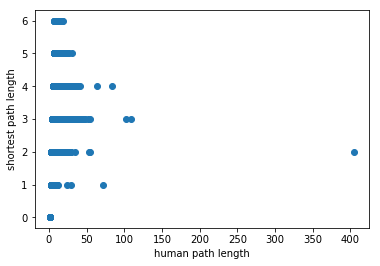

In [34]:
plt.scatter(human_paths, shortest_paths)
plt.xlabel("human path length")
plt.ylabel("shortest path length")
plt.show()

*Most people reached their destination within 50 clicks and one unfortunate soul had to click more than 400 times to reach a destination that could be reached in just 2 clicks.* 

* Is there a correlation between human/shortest path-lengths? What is the correlation.

**Answer:**  There’s a positive correlation between human and shortest path lengths. I.e. the longer the shortest path tends to be, so too does the human path length tend to increase. 

In [35]:
print round(np.corrcoef(human_paths, shortest_paths)[0,1], 3)

0.302


### IIb: Betweenness

An interesting definition of centrality is _betweenness centrality_. In a traditional setting, this measure calculates all shortest paths in the network and then each node gets a score according to which fraction of all shortest paths pass through that node.

In this part of the assignment, we create our own version of centrality, based on the _source_/_target_ pairs in our dataset. We define a nodes's **navigation centrality** as follows. 

> *Navigation centrality* of node $i$ is the fraction of all naviagtion paths that pass through $i$. We exclude the source and target from the count. If a node has not been visited by a search, the navigation centrality of that node is defined to be zero.

Below, we investigate the relationship between navigation centrality and betweenness centrality.

**Data setup:**

In [36]:
# implement definition of navigation centrality
def navigation_centrality(graph, path_list):
    # find all pages used in direct paths
    # (i.e. not counting backclicks and pages backclicked from)
    pages = []
    for path in path_list:
        for page in path.split(";")[1:-1]: # skipping first and last page
            if page != "<":
                pages += [page] # add page
            else:
                pages = pages[:-1] # remove previous page on backclick
    
    # calculate average number of page occurences per path
    nav = {page: float(pages.count(page))/(float(len(path_list))) for page in graph.nodes()}
    return nav

Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset.
Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.

In [37]:
# calculate centralities
between = nx.betweenness_centrality(wiki)
navigation = navigation_centrality(wiki, paths_succ["path"])

# add centralities to graph
nx.set_node_attributes(wiki, 'betweenness', between)
nx.set_node_attributes(wiki, 'navigation', navigation)



* First, list the 5 pages with highest navigation centrality.


**Answer:**

In [38]:
nav_top = sorted(wiki.node, key=lambda x:wiki.node[x]['navigation'], reverse=True)

print "Top 5: Navigation Centrality"
for i, n in enumerate(nav_top[:5]):
    print "#{} - {}: {}".format(i+1, n, round(wiki.node[n]['navigation'], 3))

Top 5: Navigation Centrality
#1 - United_States: 0.166
#2 - Europe: 0.081
#3 - United_Kingdom: 0.071
#4 - Earth: 0.06
#5 - England: 0.057


* Second, list the 5 pages with highest betweenness centrality.


**Answer:**

In [39]:
btwn_top = sorted(wiki.node, key=lambda x:wiki.node[x]['betweenness'], reverse=True)

print "Top 5: Betweenness Centrality"
for i, n in enumerate(btwn_top[:5]):
    print "#{} - {}: {}".format(i+1, n, round(wiki.node[n]['betweenness'], 3))

Top 5: Betweenness Centrality
#1 - United_States: 0.094
#2 - United_Kingdom: 0.042
#3 - England: 0.032
#4 - Europe: 0.027
#5 - Africa: 0.024


* Compare the two lists. Explain the differences between the two lists in your own words.


**Answer:** The two lists are quite similar as they both contain geographic areas, and roughly the same geographic areas appear in both lists. 

One difference is that humans like to navigate to the more abstract concept of “Earth” more than it’s actual path betweenness centrality warrants. Supposedly navigating to e.g. “Africa” would provide a relatively better vantage point to navigate from, as can be seen from the betweenness centrality top 5. 

Another difference is that people like to navigate to “Europe” over “United_Kingdom” and “England” directly, although the betweenness centrality of the latter two actually suggests “Europe” would be less helpful for further navigation than the latter two.

* Create a scatterplot of betweenness centrality vs. navigation centrality.


**Answer:**


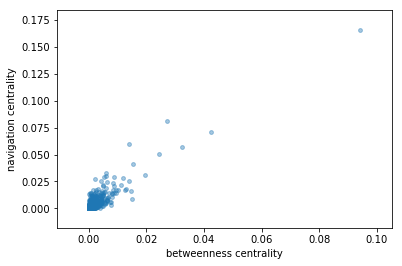

In [40]:
btwn = [n['betweenness'] for n in wiki.node.values()]
nav = [n['navigation'] for n in wiki.node.values()]

plt.scatter(btwn, nav, alpha=0.4, s=15)
plt.xlabel("betweenness centrality")
plt.ylabel("navigation centrality")
plt.show()



*Looking at the plot, the two definitions seem fairly well-correlated.*

Let's explore the pages that have navigation centrality equal to zero.
  * How many pages have zero navigation centrality?
 


**Answer:** 

In [41]:
nav0 = [n for n in wiki.node if wiki.node[n].values()[1] == 0]
print "Pages with zero navigation centrality:", len(nav0), "(~{}%)".format(
    round(100.0*float(len(nav0))/float(len(wiki.node.values())), 1))

Pages with zero navigation centrality: 1322 (~28.8%)


* What is the the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).


**Answer:** 

In [42]:
btwn0 = {n: wiki.node[n]['betweenness'] for n in nav0}
maxbtwn = max(btwn0, key=btwn0.get)
print "Node with max betweenness and no navigation centrality:", maxbtwn
print wiki.node[maxbtwn]

Node with max betweenness and no navigation centrality: TGV
{'betweenness': 0.0011241565075453248, 'navigation': 0.0}


TGV is apparantly France’s intercity high-speed rail service. It makes sense that this would have a high betweenness centrality as the wikipage contains links to a lot of destination cities and other transportation services around the world. But it also makes sense that noone navigates to TGV as to most humans, it’s not really clear what TGV even is in the first place.

* Plot the distribution of betweenness centrality for the pages with zero navigation centrality.

**Answer:**

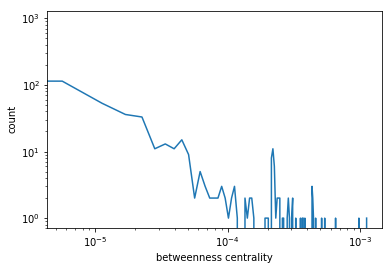

In [43]:
btwn_hist = np.histogram(btwn0.values(), bins=200)

plt.plot(btwn_hist[1][:-1], btwn_hist[0])
plt.xlabel("betweenness centrality")
plt.ylabel("count")
plt.xscale('log')
plt.yscale('log')
plt.show()

*count shows how many wiki pages have a given betweenness centrality*

*The majority of pages have a small betweenness centrality*

* Now, let's *throw out all pages with zero navigation centrality* and compare navigation- and betweenness centrality for the remaining pages.
 


**Answer:**

In [44]:
filtered = {n: [wiki.node[n]['navigation'], 
                wiki.node[n]['betweenness']] 
            for n in wiki.nodes() if n not in nav0}

 * What is the correlation between betweenness centrality and navigation centrality?

**Answer:**

In [45]:
coef = np.corrcoef([v[0] for v in filtered.values()], 
                   [v[1] for v in filtered.values()])
print "Correlation between betweenness and navigation centrality:", round(coef[0,1], 2)

Correlation between betweenness and navigation centrality: 0.91


  * Comment on the top 5 outliers.

**Answer:** 

In [46]:
x = {n: cent[0]+cent[1] for n, cent in filtered.iteritems()}
outliers = sorted(x, key=x.get, reverse=True)[:5]
for i, n in enumerate(outliers):
    print "#{} - {}".format(i+1, n)

#1 - United_States
#2 - United_Kingdom
#3 - Europe
#4 - England
#5 - Africa


To further investigate the the top 5 outliers shown above, the scatterplot is remade with annotations:

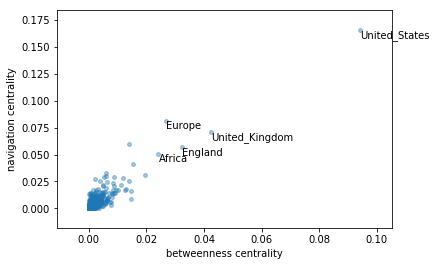

In [29]:
plt.scatter([v[1] for v in filtered.values()], [v[0] for v in filtered.values()], alpha=0.4, s=15)
plt.xlabel("betweenness centrality")
plt.ylabel("navigation centrality")
for name in outliers:
    plt.annotate(name, (filtered[name][1], filtered[name][0]),
                 verticalalignment='top')
plt.show()

This plot displays the outliers to be fairly well aligned between navigation and betweenness centrality.

### IIc: Bringing the text into the picture

Now that we have an idea about the differences between how humans and computers search in networks, we are going to dig a little deeper using the page content to test a hypothesis to explain why the human navigation paths are longer. The general idea is that humans (who don't know about the global network structure) tend to jump between pages that have related _content_. For this reason we expect that (on average) human navigation paths have more similar content than the shortest paths in the network (which might take 'surprising' shortcuts via relatively unrelated pages). In short.

> **Hypothesis H1**: Human navigation paths have more similar content than network shortest paths.

The way we'll test this hypothesis is to first represent each page as a vector using a bag-of-words approach, then we can calculate a distance between pairs of pages using some vector-space difference, and finally we'll characterize each path by its average pair-wise distance. Below, I've set up that process as an exercise. 

**Data setup:**

First, create a TF-IDF vector for each page based on the ascii version of the page texts. 

Second, write a function that calculates the distance between a pair of vectors. There are many ways to calculate distances between a pair of vectors (try a Google search for `vector space distance measures` if you want to refresh your knowledge on this topic). You're free to choose what you want, but we recommend the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

Now you're ready to get started

* Calculate the average pairwise similarity for all human navigation paths (the _source_/_target_ pairs from above). With start and end at node $i,j$ we can call this similarity $s_{i,j}$. Calculate mean/variance of the $s_{ij}$'s.
* Calculate the average pairwise similarity for all shortest paths between the _source_/_target_ pairs ($S_{i,j}$). Calculate mean/variance of the $S_{i,j}$.
* Plot the distributions of average pairwise similarities for both human- and shortest paths in a single plot. If everything works well, you should see something similar to the following:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2017/master/files/path-similarity.png)
* Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.
* Comment on your findings. Is **H1** true?

# Part III

Exercise, sentiment over some books from NLPP1e

**Data setup:**

In [47]:
# import books
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


* Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.

**Answer:**

In [48]:
# Import the word list. Pandas provides a really neat way of doing this. 
path = 's001.txt'
wordList = pd.read_csv(path, skiprows=2, sep='\t', index_col=0)

The list was generated by first collecting the 5000 most frequent words from Twitter, Google Books, music lyrics and the New York Times, then asking users on Amazon Mechanical Turk to evaluate how a given word made them feel on a scale from 1 (unhappy) to 9 (happy). The last four columns reflect the frequency of occurence for a given word in the specified corpus. NaN indicates the given word was not found among the top 5000 words of the given corpus.

* Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc). The function should complain if there are no words with sentiment attached.


**Answer:**

In [49]:
# Calculate mean for entire file 
happiness = (wordList.happiness_average).to_dict()  

def calcSentiment(tokens):
    #s = sum([happiness.get(token.lower(), 0.0) for token in tokens])
    s = 0
    count = 0
    for token in tokens:
        try:
            s += happiness[token]
            count += 1 
        except:
            pass
    # Empty check -> Fail gracefully
    if s == 0: 
        raise ValueError('The list must contain at least one token found in LabMT word list.')
    return s / count

* Calculate a sentiment profile for the novels in NLPP1e chapter 1\. The sentiment profile has sentiment on the $y$-axis and position in the text on the $x$-axis. Use a moving average to show how the sentiment changes. Create profiles for sliding windows of length 50 words, 100 words, 500 words.


**Answer:**

In [50]:
# Tokenize all the texts
textTokens = [text1.tokens, text2.tokens, text3.tokens, text4.tokens, text5.tokens, text6.tokens, text7.tokens, text8.tokens, text9.tokens]

In [51]:
#Generates all plot data for entire text
def sentimentSlicer(n):
    result = []
    for idx, text in enumerate(textTokens):        
        result.append(textstepper(text, n))
    return result

#runs through all tokens for text and looks at n words at a time. Returns happiness plot data.
def textstepper(tokens, n):
    result = []
    skipped = 0
    for i in xrange(n+1, len(tokens)): 
        startidx = max(0, i-n)
        split = tokens[startidx:i]
        try:
            result.append(calcSentiment(split))     
        except ValueError:
            skipped+=1
    print ('%s slices were without words in LabMT.' % (skipped))        
    return result

In [ ]:
#Setup profiles of sliding windows of 50, 100 and 500 words for one text
profile50 = textstepper(textTokens[0], 50)
profile100 = textstepper(textTokens[0], 100)
profile500 = textstepper(textTokens[0], 500)
#print amount of skipped slices due to no found sentiment words

102 slices were without words in LabMT.
0 slices were without words in LabMT.
0 slices were without words in LabMT.


In [ ]:
#Setup profiles of sliding windows of 500 for all texts
profile500all = sentimentSlicer(500)

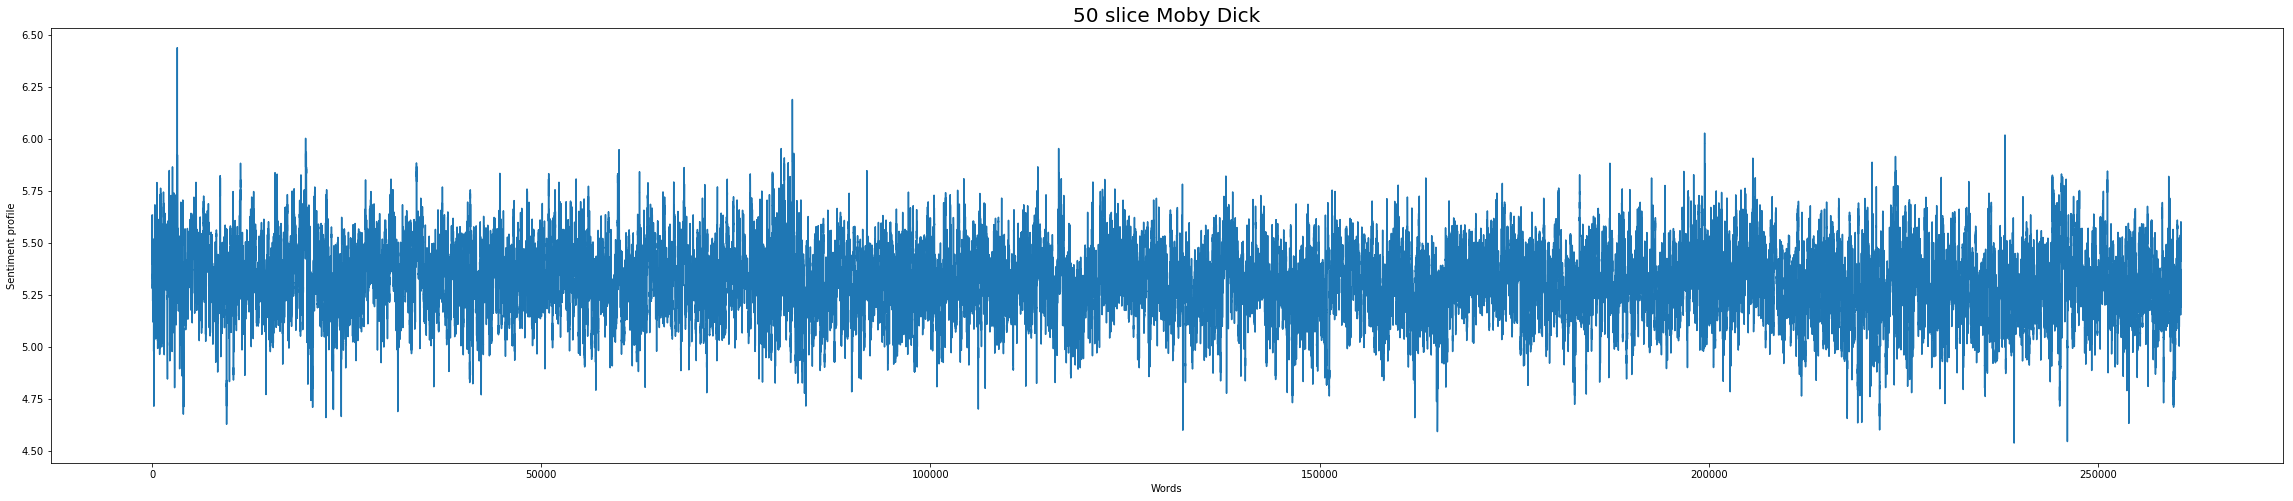

In [37]:
#plot sliding window of 50 for one text
fig = plt.figure(figsize=(40,8))
plt.plot(profile50)
plt.xlabel("Words")
plt.ylabel("Sentiment profile")
plt.title("50 window Moby Dick", fontsize=20)
plt.show()

*With a small sliding window of 50 the datapoints become very dispersed*

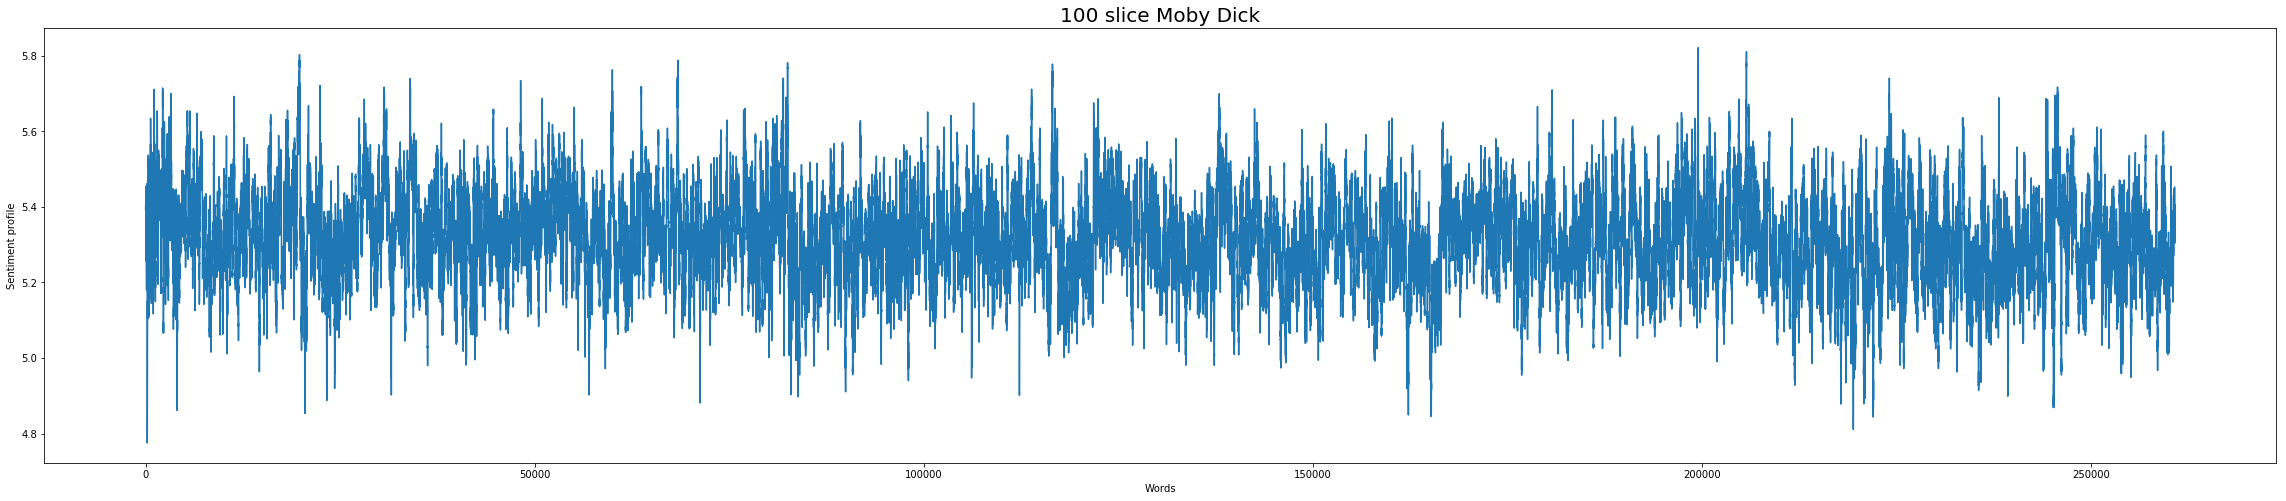

In [38]:
#plot sliding window of 100 for one text
fig = plt.figure(figsize=(40,8))
plt.plot(profile100)
plt.xlabel("Words")
plt.ylabel("Sentiment profile")
plt.title("100 window Moby Dick", fontsize=20)
plt.show()

*It does not seem like a big improvement with the slide window of 100 vs 50*

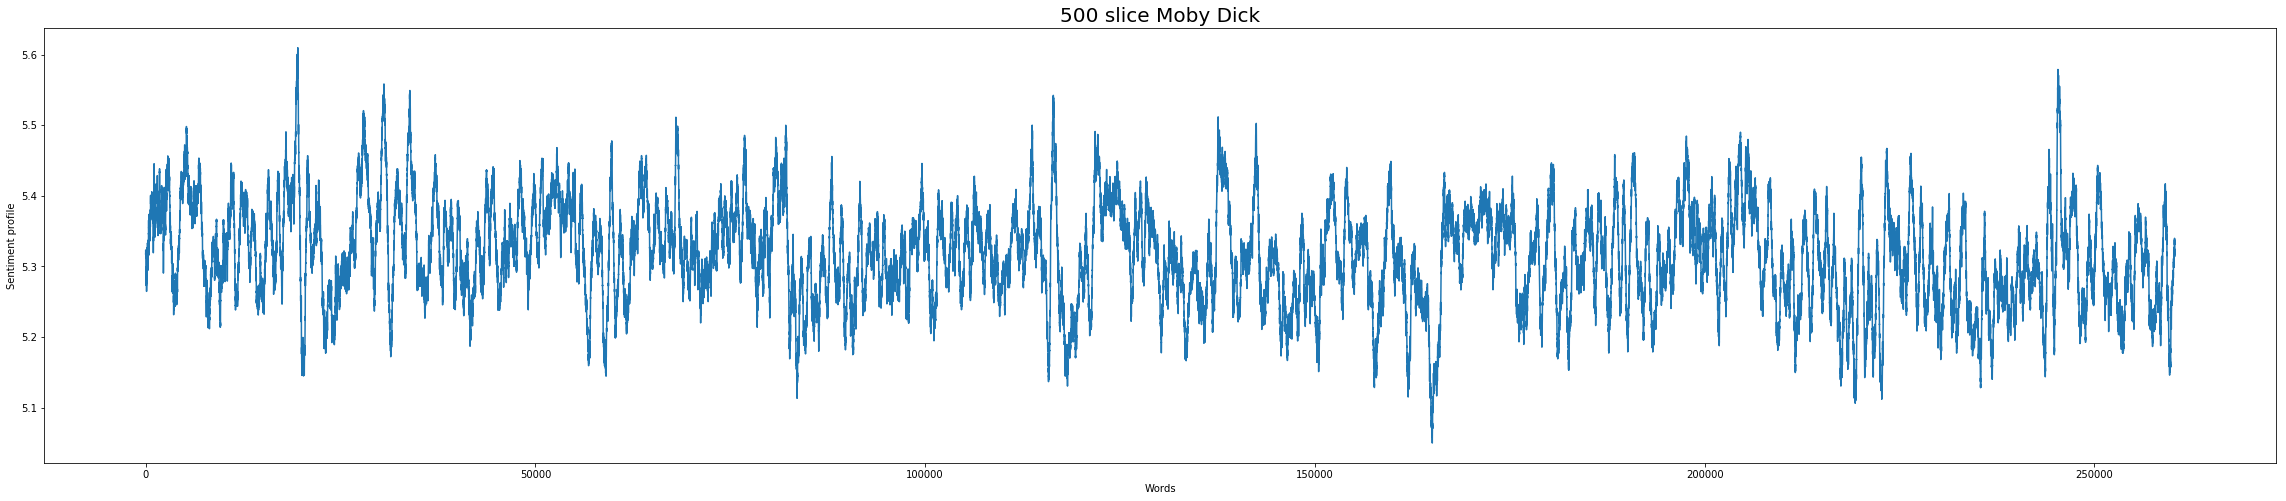

In [39]:
#plot sliding window of 500 for one text
fig = plt.figure(figsize=(40,8))
plt.plot(profile500)
plt.xlabel("Words")
plt.ylabel("Sentiment profile")
plt.title("500 window Moby Dick", fontsize=20)
plt.show()

*With a sliding window of 500 it becomes much easier to spot general trends during the text*

In [45]:
#Setting up plots for the three novels, text 1, text 2 and text 9.
profile500novels0 = textstepper(textTokens[0], 500)
profile500novels1 = textstepper(textTokens[1], 500)
profile500novels8 = textstepper(textTokens[8], 500)

0 slices were without words in LabMT.
0 slices were without words in LabMT.
0 slices were without words in LabMT.


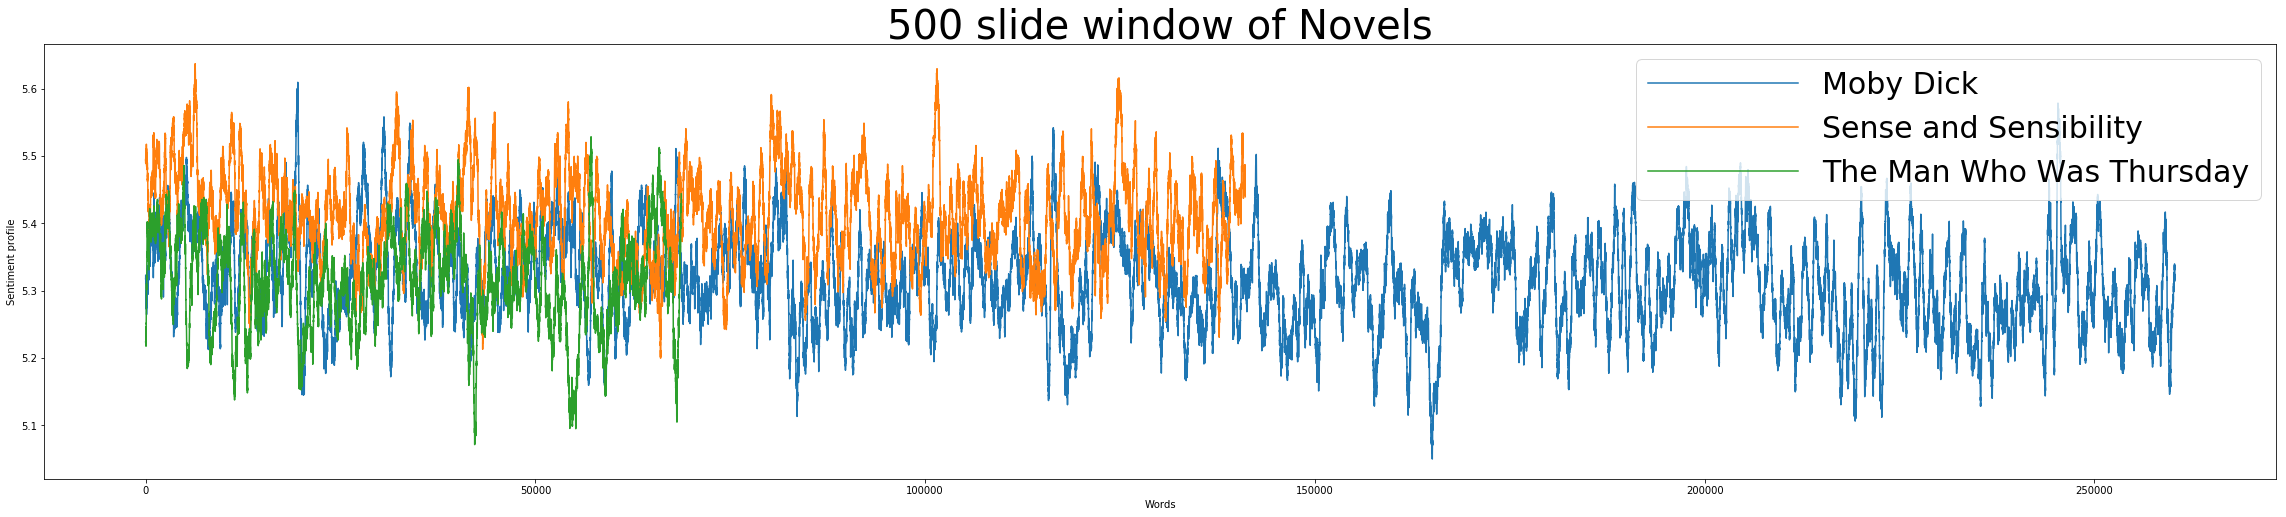

In [50]:
fig = plt.figure(figsize=(40,8))
plt.plot(profile500novels0)
plt.plot(profile500novels1)
plt.plot(profile500novels8)
plt.xlabel("Words")
plt.ylabel("Sentiment profile")
plt.legend(['Moby Dick','Sense and Sensibility','The Man Who Was Thursday'])
plt.title("500 slide window of Novels", fontsize=40)
plt.show()

*When using the 3 text novels, it becomes clear that all texts adhere to the same pattern. "Sense and Sensibility" is generally more happy than the other two but other than that, the graphs ends in roughly the same y point as they start.*

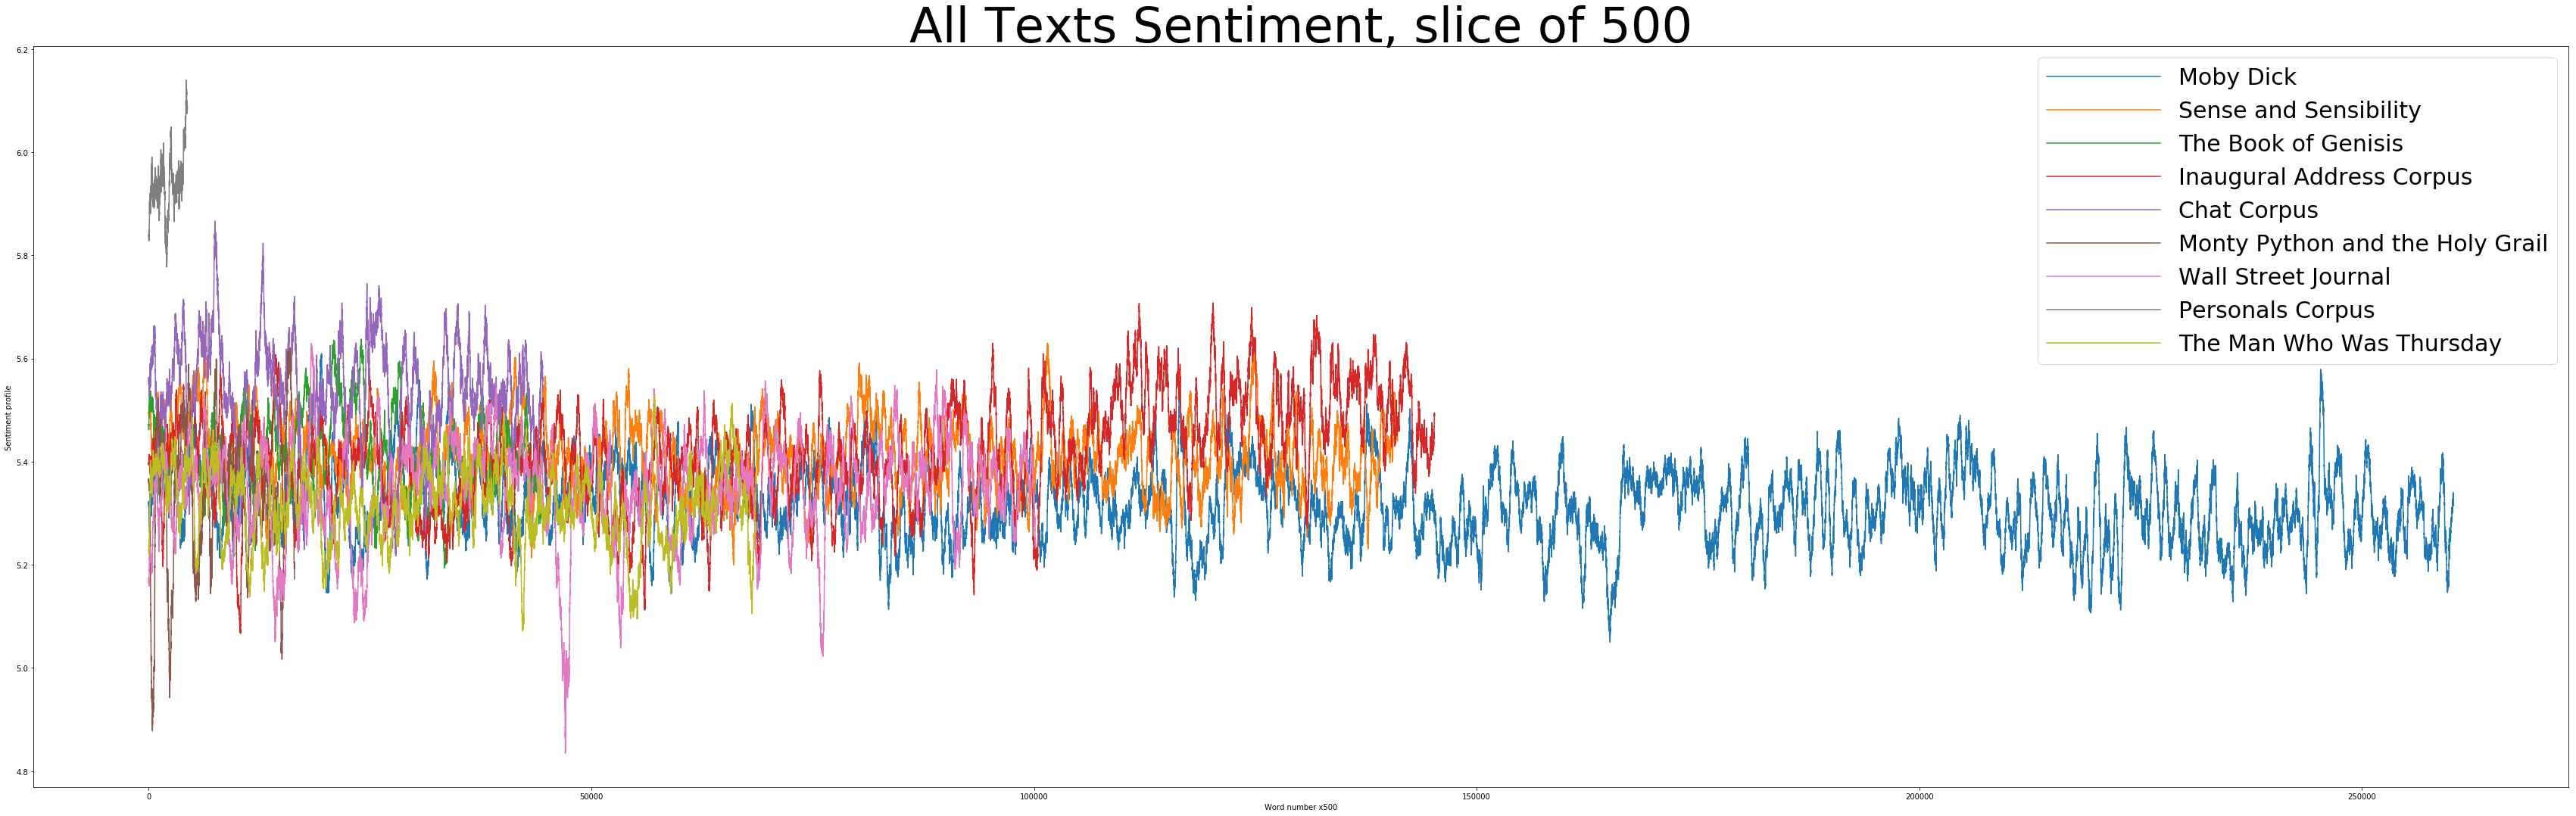

In [44]:
#Plot sliding windows of 500 for all texts for general overview

#Adjusting fontsize of the legend
params = {'legend.fontsize': 30,
'legend.handlelength': 5}
plt.rcParams.update(params)

fig = plt.figure(figsize=(60,18))
for i in range(0, 9):
    plt.plot(profile500all[i])
plt.xlabel("Word number x500")
plt.ylabel("Sentiment profile")
plt.legend(['Moby Dick','Sense and Sensibility','The Book of Genisis','Inaugural Address Corpus','Chat Corpus','Monty Python and the Holy Grail','Wall Street Journal','Personals Corpus','The Man Who Was Thursday'])
plt.title("All Texts Sentiment, window of 500", fontsize=64)
plt.show()

*Portraying all text sentiments in one plot makes for a messy presentation, but it is interesting to see how closely all the texts are in overall sentiment, and it makes it easy to point out that the "Personals Corpus" apparently is the happiest text.*

* Comment on the sentiment profiles. Do they show a similar pattern? What is the effect of changing the size of the sliding window?

**Answer:** 
The profiles within the same sliding windows show a very similar pattern that seems to follow the same average sentiment throughout the entire text. This holds true for all the texts. By changing the sliding window the datapoints shown are based on a larger average giving a better visual representation of the overall sentiment of the text. 

It is important to note that we have included non-sentiment tokens in the sliding windows thus giving the individual sentiment token a higher weight, which gives a higher disparity in the datapoints. By only including sentiment tokens in the sliding window, each new sentiment token added will have its value divided across a lot more sentimet token values, meaning the overall sliding window will experince much less disparity.